In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-reviews-unlocked-mobile-phones/Amazon_Unlocked_Mobile.csv


In [35]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout,Input,LSTM,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.layers import Bidirectional

In [4]:
df = pd.read_csv('../input/amazon-reviews-unlocked-mobile-phones/Amazon_Unlocked_Mobile.csv')

In [5]:
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [6]:
df.shape

(413840, 6)

In [7]:
df = df.drop(['Price', 'Review Votes'], axis=1)

In [8]:
df.isnull().sum()

Product Name        0
Brand Name      65171
Rating              0
Reviews            62
dtype: int64

In [9]:
df['Brand Name'].fillna('Unknown', inplace = True)

In [10]:
drop_rows = df.index[df['Reviews'].isnull()]
df = df.drop(list(drop_rows))

In [11]:
df.isnull().sum()

Product Name    0
Brand Name      0
Rating          0
Reviews         0
dtype: int64

<AxesSubplot:>

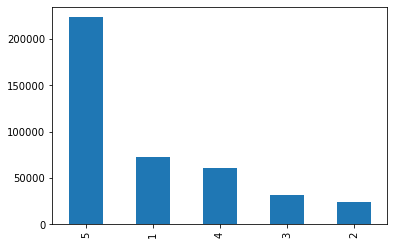

In [12]:
df['Rating'].value_counts().plot.bar()

In [13]:
'''Sentiment : 
    2 - Positive,
    1 - Neutral,
    0 - Negative
'''
df['Sentiment'] = df['Rating'].replace({5 : 2,
                                        4 : 2,
                                        3 : 1,
                                        2 : 0,
                                        1 : 0})

<AxesSubplot:>

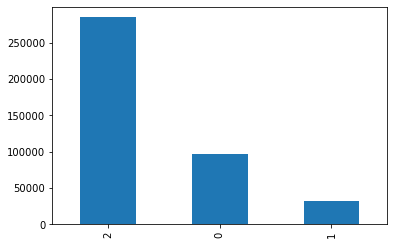

In [14]:
df['Sentiment'].value_counts().plot.bar()

In [15]:
X = df.drop(columns = ['Sentiment'])
y = df['Sentiment']

In [16]:
X.shape, y.shape

((413778, 4), (413778,))

In [17]:
stopwords = set(stopwords.words('english'))

In [18]:
sb = SnowballStemmer(language='english')
corpus = []
for sent in X['Reviews']:
    review = re.sub('[^A-Za-z0-9]+', ' ', str(sent))
    review = review.lower()
    review = review.split()
    
    review = [sb.stem(word) for word in review if not word in stopwords]
    review = ' '.join(review)
    corpus.append(review)

In [19]:
len(corpus)

413778

In [20]:
voc_size = 50000
max_length = 150
embedding_features = 32

In [21]:
tokenizer = Tokenizer(num_words = voc_size, oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)

In [22]:
sequences = tokenizer.texts_to_sequences(corpus)
embedded_docs = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [23]:
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [24]:
X_final.shape, y_final.shape

((413778, 150), (413778,))

In [25]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
class performance_metric(tf.keras.callbacks.Callback):

    def __init__(self,validation_data):
      self.x_test = validation_data[0]
      self.y_test= validation_data[1]


    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'f1_val': [],'precision_val' : [], 'recall_val' :[], 'val_accuracy' : []}

    def on_epoch_end(self, epoch, logs = {}):

        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))

        test_pred= self.model.predict(self.x_test)
        pred_labels = []
        for probs in test_pred:
            label = np.argmax(probs, axis=-1)
            pred_labels.append(int(label))

        f1_test = f1_score(y_test , np.array(pred_labels) , average = 'weighted')
        precision = precision_score(y_test , np.array(pred_labels) , average = 'weighted')
        recall = recall_score(y_test , np.array(pred_labels) , average = 'weighted')
        
        
        self.history['f1_val'].append(f1_test)
        print("F1: ", f1_test)
        
        self.history['precision_val'].append(precision)
        print("Precision: ", precision)
        
        self.history['recall_val'].append(recall)
        print("Recall: ", recall)

In [26]:
model = Sequential()
model.add(Embedding(voc_size, embedding_features, input_length=max_length))
model.add(Dropout(0.33))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.33))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 32)           1600000   
_________________________________________________________________
dropout (Dropout)            (None, 150, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [28]:
to_categorical(y_train)

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [29]:
X_train.shape, X_test.shape

((277231, 150), (136547, 150))

In [30]:
y_train.shape, y_test.shape

((277231,), (136547,))

In [31]:
metrics = performance_metric(validation_data=[X_test, to_categorical(y_test)])

In [32]:
model.fit(X_train, to_categorical(y_train), validation_data=(X_test, to_categorical(y_test)), epochs = 1, batch_size=64,
          callbacks = metrics)

4332/4332 [==============================] - 104s 23ms/step - loss: 0.4232 - accuracy: 0.8525 - val_loss: 0.3695 - val_accuracy: 0.8650
F1:  0.8395759476442956
Precision:  0.8377351166224813
Recall:  0.8649768944026599


In [33]:
predictions = model.predict(X_test)
predictions

array([[6.5483525e-04, 4.8050182e-03, 9.9454015e-01],
       [3.1431413e-01, 3.3986086e-01, 3.4582496e-01],
       [6.0380745e-04, 4.3495493e-03, 9.9504662e-01],
       ...,
       [4.8874855e-02, 6.5327309e-02, 8.8579780e-01],
       [1.8373999e-04, 2.3937067e-03, 9.9742258e-01],
       [1.3986945e-02, 5.4496601e-02, 9.3151641e-01]], dtype=float32)

In [47]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, predictions.argmax(axis=1), labels = [0,1,2])
matrix

array([[25873,   545,  5548],
       [ 3444,   794,  6162],
       [ 2351,   387, 91443]])

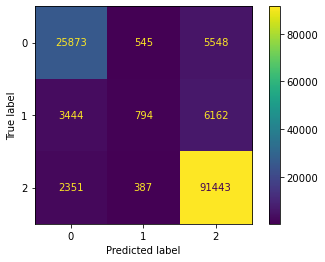

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
a = ConfusionMatrixDisplay(matrix)
a.plot()

In [45]:
a